# Analyse Imports

This notebook:
- Analyses the most popular imports.
- Constructs a graph to determine the number of import 'hops' from a module to an ML-related import. 
- Categorises paths in each repo as ML0 (direct user of ML), ..., ML4 (indirect user of ML), unittests, or other

In [1]:
import pandas as pd
import numpy as np
from os.path import join
import altair as alt # Python wrapper for Vega-Lite visualisation grammar

In [2]:
DATA_DIR = "../output/"

## Merge Python2 and Python3 import results

The corpus contains a mix of Python2 and Python3 repos. As we can't detect the language reliably, the `findimports` tool was run as both Python2 and Python3. We treat the set of imports for a repository as the combined set of imports detected when analysing as Python2 or as Python3.

We start by loading the Python2 results:

In [3]:
proj_imports2 = pd.read_csv(join(DATA_DIR, "results_imports_python2.csv"))

In [4]:
proj_imports2

,repo,path,module_name,import_name,parse_error
0,72225778,72225778/predict.py,predict,data_helper,False
1,72225778,72225778/predict.py,predict,json,False
2,72225778,72225778/predict.py,predict,logging,False
3,72225778,72225778/predict.py,predict,numpy,False
4,72225778,72225778/predict.py,predict,os,False
...,...,...,...,...,...
44211,40576835,40576835/api_benchmarks.py,api_benchmarks,settings,False
44212,40576835,40576835/api_benchmarks.py,api_benchmarks,time,False
44213,40576835,40576835/api_benchmarks.py,api_benchmarks,urllib,False
44214,40576835,40576835/api_benchmarks.py,api_benchmarks,urllib2,False


In [5]:
proj_imports2.nunique()[["repo", "path", "module_name", "import_name"]]

repo             222
path            7941
module_name     6635
import_name    10903
dtype: int64

In [6]:
# Number of cases where file had a parse error
len(proj_imports2[proj_imports2["parse_error"]])

687

In [7]:
# Number of cases where a module name could not be extracted (should be equal to number of parse errors)
len(proj_imports2[pd.isnull(proj_imports2["module_name"])])

687

All 222 repositories are listed. However, some of these had parse errors, and thus the module name and imports could not be extracted.

In [8]:
# Example of how unparsable repositories are represented
proj_imports2[proj_imports2["parse_error"]].head()

,repo,path,module_name,import_name,parse_error
610,79748320,79748320/bn_lstm_test.py,NaN,NaN,True
806,44304626,44304626/pipeline_caller.py,NaN,NaN,True
2030,13884324,13884324/lib/oauthlib/oauth2/rfc6749/grant_typ...,NaN,NaN,True
3499,18766036,18766036/iepy/webui/corpus/fields.py,NaN,NaN,True
4111,77662713,77662713/bin/train_model.py,NaN,NaN,True


We now repeat for the Python3 results:

In [9]:
proj_imports3 = pd.read_csv(join(DATA_DIR, "results_imports_python3.csv"))
proj_imports3

,repo,path,module_name,import_name,parse_error
0,72225778,72225778/predict.py,predict,data_helper,False
1,72225778,72225778/predict.py,predict,json,False
2,72225778,72225778/predict.py,predict,logging,False
3,72225778,72225778/predict.py,predict,numpy,False
4,72225778,72225778/predict.py,predict,os,False
...,...,...,...,...,...
43599,88318858,88318858/batchgen.py,NaN,NaN,True
43600,88318858,88318858/train.py,NaN,NaN,True
43601,40576835,40576835/get_accuracies.py,NaN,NaN,True
43602,40576835,40576835/api_benchmarks.py,NaN,NaN,True


In [10]:
proj_imports3.nunique()[["repo", "path", "module_name", "import_name"]]

repo             222
path            7941
module_name     6427
import_name    10460
dtype: int64

In [11]:
len(proj_imports3[proj_imports3["parse_error"]])

989

In [12]:
len(proj_imports3[pd.isnull(proj_imports3["module_name"])])

989

We now merge the results for Python2 and Python3 into a single DataFrame. There are 4 cases to consider:
1. Code file parsed as Python2 only (dataframe will list all Python2 imports, plus one empty row for the failed Python3 import analysis)
2. Code file parsed as Python3 only (dataframe will list all Python3 imports, plus one empty row for the failed Python2 import analysis)
3. Code file parsed as both Python2 and Python3 (dataframe will list imports for both, leading to some duplicated rows)
4. Code file parsed as neither Python2 nor Python3 (dataframe will list two empty rows, one for each failed import analysis. This should be rare)

The analysis will focus on the number of repositories that contain an import, and which modules import each other. The analysis does not attempt to analyse the number of imports per repository, thus is unaffected by duplicates arising as a result of case 3.

In [13]:
proj_imports_all = pd.concat([proj_imports2, proj_imports3], ignore_index=True)

In [14]:
proj_imports_all

,repo,path,module_name,import_name,parse_error
0,72225778,72225778/predict.py,predict,data_helper,False
1,72225778,72225778/predict.py,predict,json,False
2,72225778,72225778/predict.py,predict,logging,False
3,72225778,72225778/predict.py,predict,numpy,False
4,72225778,72225778/predict.py,predict,os,False
...,...,...,...,...,...
87815,88318858,88318858/batchgen.py,NaN,NaN,True
87816,88318858,88318858/train.py,NaN,NaN,True
87817,40576835,40576835/get_accuracies.py,NaN,NaN,True
87818,40576835,40576835/api_benchmarks.py,NaN,NaN,True


## [Optional] Differences between findimports results for Python2 and Python3

As different versions of `findimports` was used for Python2 and Python3, we check whether the import results were consistent when a file parsed as both Python2 and Python3.

In [15]:
unsplit2 = proj_imports2.groupby(["repo", "path", "parse_error"]).agg(lambda x: ";".join([str(i) for i in x if not pd.isna(i)]))
unsplit_flat2 = pd.DataFrame(unsplit2.to_records())
unsplit_flat2

,repo,path,parse_error,module_name,import_name
0,41590,41590/nlp/counter.py,False,counter;counter;counter;counter;counter,collections;math;nlp.counter;os;random
1,41590,41590/nlp/countermap.py,False,countermap;countermap;countermap;countermap;co...,copy;counter;itertools;math;numpy
2,41590,41590/nlp/crp.py,False,crp,datetime
3,41590,41590/nlp/cythonsetup.py,False,cythonsetup;cythonsetup;cythonsetup,Cython.Distutils.build_ext;distutils.core;dist...
4,41590,41590/nlp/distributions.py,False,distributions;distributions;distributions;dist...,countermap;future_math.gaussian_cdf;lib.mvncdf...
...,...,...,...,...,...
7936,119537109,119537109/utils/oracle/OracleLstm.py,False,utils.oracle.OracleLstm;utils.oracle.OracleLst...,numpy;tensorflow;tensorflow.python.ops.control...
7937,119537109,119537109/utils/oracle/OracleSru.py,False,utils.oracle.OracleSru;utils.oracle.OracleSru;...,numpy;tensorflow;tensorflow.python.ops.control...
7938,119537109,119537109/utils/oracle/__init__.py,False,utils.oracle.__init__,
7939,119537109,119537109/utils/text_process.py,False,utils.text_process,nltk


In [16]:
unsplit3 = proj_imports3.groupby(["repo", "path", "parse_error"]).agg(lambda x: ";".join([str(i) for i in x if not pd.isna(i)]))
unsplit_flat3 = pd.DataFrame(unsplit3.to_records())
unsplit_flat3

,repo,path,parse_error,module_name,import_name
0,41590,41590/nlp/counter.py,True,,
1,41590,41590/nlp/countermap.py,True,,
2,41590,41590/nlp/crp.py,True,,
3,41590,41590/nlp/cythonsetup.py,False,cythonsetup;cythonsetup;cythonsetup,Cython.Distutils.build_ext;distutils.core;dist...
4,41590,41590/nlp/distributions.py,False,distributions;distributions;distributions;dist...,countermap;future_math.gaussian_cdf;lib.mvncdf...
...,...,...,...,...,...
7936,119537109,119537109/utils/oracle/OracleLstm.py,False,utils.oracle.OracleLstm;utils.oracle.OracleLst...,numpy;tensorflow;tensorflow.python.ops.control...
7937,119537109,119537109/utils/oracle/OracleSru.py,False,utils.oracle.OracleSru;utils.oracle.OracleSru;...,numpy;tensorflow;tensorflow.python.ops.control...
7938,119537109,119537109/utils/oracle/__init__.py,False,utils.oracle.__init__,
7939,119537109,119537109/utils/text_process.py,False,utils.text_process,nltk


In [17]:
joined = pd.merge(unsplit_flat2, unsplit_flat3,
                  how='outer',
                  on=['repo', 'path'],
                  suffixes=('2', '3'))
joined

,repo,path,parse_error2,module_name2,import_name2,parse_error3,module_name3,import_name3
0,41590,41590/nlp/counter.py,False,counter;counter;counter;counter;counter,collections;math;nlp.counter;os;random,True,,
1,41590,41590/nlp/countermap.py,False,countermap;countermap;countermap;countermap;co...,copy;counter;itertools;math;numpy,True,,
2,41590,41590/nlp/crp.py,False,crp,datetime,True,,
3,41590,41590/nlp/cythonsetup.py,False,cythonsetup;cythonsetup;cythonsetup,Cython.Distutils.build_ext;distutils.core;dist...,False,cythonsetup;cythonsetup;cythonsetup,Cython.Distutils.build_ext;distutils.core;dist...
4,41590,41590/nlp/distributions.py,False,distributions;distributions;distributions;dist...,countermap;future_math.gaussian_cdf;lib.mvncdf...,False,distributions;distributions;distributions;dist...,countermap;future_math.gaussian_cdf;lib.mvncdf...
...,...,...,...,...,...,...,...,...
7936,119537109,119537109/utils/oracle/OracleLstm.py,False,utils.oracle.OracleLstm;utils.oracle.OracleLst...,numpy;tensorflow;tensorflow.python.ops.control...,False,utils.oracle.OracleLstm;utils.oracle.OracleLst...,numpy;tensorflow;tensorflow.python.ops.control...
7937,119537109,119537109/utils/oracle/OracleSru.py,False,utils.oracle.OracleSru;utils.oracle.OracleSru;...,numpy;tensorflow;tensorflow.python.ops.control...,False,utils.oracle.OracleSru;utils.oracle.OracleSru;...,numpy;tensorflow;tensorflow.python.ops.control...
7938,119537109,119537109/utils/oracle/__init__.py,False,utils.oracle.__init__,,False,utils.oracle.__init__,
7939,119537109,119537109/utils/text_process.py,False,utils.text_process,nltk,False,utils.text_process,nltk


For projects that were both valid Python2 and Python3, we check for cases where the import list differed:

In [18]:
inconsistent = joined[(joined["import_name2"] != joined["import_name3"]) & ~joined["parse_error2"] & ~joined["parse_error3"]]
inconsistent

,repo,path,parse_error2,module_name2,import_name2,parse_error3,module_name3,import_name3
4,41590,41590/nlp/distributions.py,False,distributions;distributions;distributions;dist...,countermap;future_math.gaussian_cdf;lib.mvncdf...,False,distributions;distributions;distributions;dist...,countermap;future_math.gaussian_cdf;lib.mvncdf...
21,41590,41590/nlp/test-maxent.py,False,test-maxent;test-maxent;test-maxent;test-maxen...,counter;countermap;itertools;math;maxent;maxim...,False,test-maxent;test-maxent;test-maxent;test-maxen...,counter;countermap;itertools;math.exp;math.log...
27,41590,41590/nlp/test_naivebayes.py,False,test_naivebayes;test_naivebayes;test_naivebaye...,counter;math;naivebayes;unittest,False,test_naivebayes;test_naivebayes;test_naivebaye...,counter;math.log;naivebayes;unittest
39,118130,118130/clustering/dpm.py,False,dpm;dpm;dpm;dpm;dpm;dpm;dpm;dpm,csv;numpy;numpy.linalg.det;numpy.linalg.slogde...,False,dpm;dpm;dpm;dpm;dpm;dpm,csv;numpy;numpy.linalg;optparse;scipy.special;...
40,118130,118130/clustering/irm.py,False,irm;irm;irm;irm;irm;irm,copy;numpy;numpy.concatenate;numpy.random.bino...,False,irm;irm;irm;irm,copy;numpy;numpy.random;scipy.special
...,...,...,...,...,...,...,...,...
7742,114098658,114098658/dataloader/sst.py,False,dataloader.sst;dataloader.sst;dataloader.sst;d...,codecs;dataloader;dataloader.Dataset;numpy;opt...,False,dataloader.sst;dataloader.sst;dataloader.sst;d...,codecs;dataloader;dataloader.Dataset;numpy;opt...
7765,114098658,114098658/models/LSTMwithAttention.py,False,models.LSTMwithAttention;models.LSTMwithAttent...,models.BaseModel.BaseModel;numpy;sklearn.utils...,False,models.LSTMwithAttention;models.LSTMwithAttent...,models.BaseModel.BaseModel;numpy;sklearn.utils...
7775,114098658,114098658/trandition.py,False,trandition;trandition;trandition;trandition;tr...,dataHelper;numpy;opts;sklearn.feature_extracti...,False,trandition;trandition;trandition;trandition;tr...,dataHelper;numpy;opts;sklearn.feature_extracti...
7927,119537109,119537109/utils/metrics/DocEmbSim.py,False,utils.metrics.DocEmbSim;utils.metrics.DocEmbSi...,collections;math;nltk;numpy;random;scipy.spati...,False,utils.metrics.DocEmbSim;utils.metrics.DocEmbSi...,collections;math;nltk;numpy;random;scipy.spati...


Let's inspect a single example in more detail:

In [19]:
inconsistent.iloc[0].import_name2

'countermap;future_math.gaussian_cdf;lib.mvncdf;math;numpy;scipy.linalg;scipy.stats.chi2;scipy.stats.norm'

In [20]:
inconsistent.iloc[0].import_name3

'countermap;future_math.gaussian_cdf;lib.mvncdf;math.log;numpy;scipy.linalg;scipy.stats'

The above shows that there were inconsistencies between the imports reported by `findimports` running under Python2 and `findimports` running under Python3. However, upon closer examination it seems that most of the differences were due to the environment. In the initial attempt, scipy was installed in the Python3 environment, but not the Python2 environment. This meant that findimports in the Python2 environment was unable to detect the difference between importing scipy functions (scipy.stats.norm) versus scipy modules (scipy.stats). However, imports of local modules in the repository will have access to the source code needed to detect if the module exists.

## [Optional] Are multiple imports of the same module reported twice?

In [21]:
def import_count(proj_imports_df):
    df_import_counts = proj_imports_df.groupby(["repo", "path", "import_name"]).count()
    df_import_counts_flat = pd.DataFrame(df_import_counts.to_records())
    return df_import_counts_flat.sort_values("module_name")

In [22]:
import_count(proj_imports2)

,repo,path,import_name,module_name,parse_error
0,41590,41590/nlp/counter.py,collections,1,1
28343,48450890,48450890/sentiment_analysis.py,lib.classifier,1,1
28344,48450890,48450890/sentiment_analysis.py,lib.examples,1,1
28345,48450890,48450890/sentiment_analysis.py,threading,1,1
28346,52581991,52581991/snorkel/__init__.py,snorkel.version,1,1
...,...,...,...,...,...
14176,21467110,21467110/bin/ud/ud_train.py,json,1,1
14177,21467110,21467110/bin/ud/ud_train.py,pathlib.Path,1,1
14178,21467110,21467110/bin/ud/ud_train.py,plac,1,1
14180,21467110,21467110/bin/ud/ud_train.py,re,1,1


In [23]:
import_count(proj_imports3)

,repo,path,import_name,module_name,parse_error
0,41590,41590/nlp/cythonsetup.py,Cython.Distutils.build_ext,1,1
27738,91356408,91356408/allennlp/common/configuration.py,torch,1,1
27739,91356408,91356408/allennlp/common/configuration.py,typing,1,1
27740,91356408,91356408/allennlp/common/file_utils.py,allennlp.common.tqdm.Tqdm,1,1
27741,91356408,91356408/allennlp/common/file_utils.py,boto3,1,1
...,...,...,...,...,...
13874,33648012,33648012/rules/emacs/Snippet.py,EventLoop.getLoop,1,1
13875,33648012,33648012/rules/emacs/Snippet.py,EventLoop.pushEvent,1,1
13876,33648012,33648012/rules/emacs/Snippet.py,mdlog,1,1
13858,33648012,33648012/rules/emacs/Rust.py,rules.emacs.Cmd.Cmd,1,1


In [24]:
import_count(proj_imports_all)

,repo,path,import_name,module_name,parse_error
0,41590,41590/nlp/counter.py,collections,1,1
21367,38108816,38108816/orangecontrib/text/widgets/owsimhash.py,Orange.widgets.gui,1,1
21366,38108816,38108816/orangecontrib/text/widgets/owsimhash.py,AnyQt.QtWidgets.QFormLayout,1,1
21365,38108816,38108816/orangecontrib/text/widgets/owsimhash.py,AnyQt.QtWidgets.QApplication,1,1
21364,38108816,38108816/orangecontrib/text/widgets/owsentimen...,orangecontrib.text.sentiment.Vader_Sentiment,1,1
...,...,...,...,...,...
20199,35187829,35187829/routes/people.py,max_age,2,2
20200,35187829,35187829/routes/people.py,pprint,2,2
20201,35187829,35187829/routes/people.py,restricted,2,2
20183,35187829,35187829/routes/news.py,max_age,2,2


For any particular Python version, imports are only listed at most once. This is because `findimports` will only list the import once, even if imported multiple times in the actual source code. When merging Python2 results and Python3 results, we end up with some duplicated imports. We could drop exact duplicates, but this would not help in cases when findimports reports slightly different names under Python2 / Python3. Instead, we simply avoid analysing the data in ways that would be sensitive to duplicates.

## Identify Popular Libraries/Frameworks

To make it easier to identify popular imports (libraries/frameworks), we define the "import_short_name" to be just the top level of an import e.g. "sklearn.model_selection.train_test_split" => "sklearn".

In [25]:
proj_imports_all["import_short_name"] = proj_imports_all["import_name"].apply(lambda x: x.split(".")[0] if not pd.isnull(x) else "")

In [26]:
proj_imports_all

,repo,path,module_name,import_name,parse_error,import_short_name
0,72225778,72225778/predict.py,predict,data_helper,False,data_helper
1,72225778,72225778/predict.py,predict,json,False,json
2,72225778,72225778/predict.py,predict,logging,False,logging
3,72225778,72225778/predict.py,predict,numpy,False,numpy
4,72225778,72225778/predict.py,predict,os,False,os
...,...,...,...,...,...,...
87815,88318858,88318858/batchgen.py,NaN,NaN,True,
87816,88318858,88318858/train.py,NaN,NaN,True,
87817,40576835,40576835/get_accuracies.py,NaN,NaN,True,
87818,40576835,40576835/api_benchmarks.py,NaN,NaN,True,


In [27]:
# popularity of imports (based on number of *repos* that use them)
popular_imports = proj_imports_all.groupby(["import_short_name"])["repo"].nunique().sort_values(ascending=False)

In [28]:
popular_imports

import_short_name
                   190
os                 178
sys                162
re                 148
numpy              122
                  ... 
mnnl                 1
mmap                 1
mkl                  1
mixup                1
manual_analyses      1
Name: repo, Length: 1399, dtype: int64

In [29]:
popular_imports.to_csv("popular.csv", header=True)

Note: The top import for '' (empty string) represents no import (e.g. due to a file with no imports, or due to a file that could not be parsed under both versions of Python). It can be ignored.

## Annotated Libs

Popular imports (used by 2 or more repositories) were manually categorized as one of:
- "ML" (tensorflow, sklearn, theano, etc.)
- "NLP" (nltk, spacy, etc.)
- "STAT" (numpy, etc.)
- "WRANGLE" (pandas, etc.)
- "VIS" (mathplotlib, etc.)
- "LOCAL" (popular import names, e.g. 'models', that were actually referring to local modules in the repository)
- Blank (Python standard library, progress bar libraries, image/video processing libraries, everything else)

In [30]:
annotated_libs = pd.read_csv("popular_manually_annotated.csv")

In [31]:
# list of ML related libraries imported by 2 or more projects
ml_libs = list(annotated_libs[annotated_libs["isML"] == "Y"]["import_short_name"])
ml_libs

['sklearn',
 'tensorflow',
 'keras',
 'torch',
 'theano',
 'tflearn',
 'pytorch_pretrained_bert',
 'xgboost',
 'apex']

In [32]:
popular_imports_df = pd.DataFrame({"lib": popular_imports.index, "cnt": popular_imports.values})
popular_imports_df["lib"] = popular_imports_df["lib"].replace('', 'None')
popular_imports_df

,lib,cnt
0,None,190
1,os,178
2,sys,162
3,re,148
4,numpy,122
...,...,...
1394,mnnl,1
1395,mmap,1
1396,mkl,1
1397,mixup,1


In [33]:
popular_imports_df_ml = popular_imports_df[popular_imports_df["lib"].isin(ml_libs)]
popular_imports_df_ml

,lib,cnt
17,sklearn,57
25,tensorflow,42
48,keras,21
57,torch,18
73,theano,12
246,tflearn,3
293,pytorch_pretrained_bert,2
296,apex,2
375,xgboost,2


In [34]:
num_repos = proj_imports_all.nunique()["repo"]
num_repos 

222

Note that in order to keep the figure size reasonable, we only show ML libs, rather than all imports:

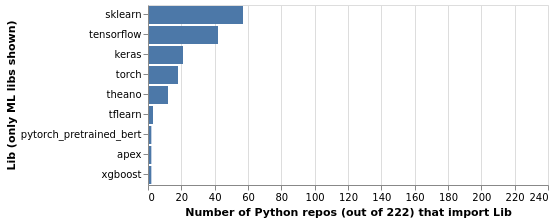

In [35]:
chart = alt.Chart(popular_imports_df_ml).mark_bar().encode(
    x = alt.X('cnt', type='quantitative', title="Number of Python repos (out of %s) that import Lib" % num_repos, scale=alt.Scale(domain=(0,int(num_repos)))),
    y = alt.Y('lib', type='nominal', title="Lib (only ML libs shown)", sort=alt.EncodingSortField(order="descending")),
)
chart

In [36]:
chart.save("imports.png")

## [Optional] Which ML libraries are used together in projects?

Some projects will use a combination of libraries. Inspired by https://blog.bitergia.com/2018/04/02/a-preliminary-analysis-on-the-use-of-python-notebooks/, an attempt was made to examine which libraries were used together. (Note that for now we just analyse combinations of ML libraries, else there are too many combinations to make sense of)

In [37]:
import_sets = []
proj_imports_grouped = proj_imports_all.groupby("repo")
for repo,repo_df in proj_imports_grouped:
    libs_set = tuple(sorted(set(repo_df["import_short_name"]) & set(ml_libs))) # empty tuple if none
    import_sets.append([repo, libs_set])

import_sets_df = pd.DataFrame.from_records(import_sets, columns=["repo", "importset"])

For each repo, which ML related libraries it uses:

In [38]:
import_sets_df

,repo,importset
0,41590,()
1,118130,"(sklearn, tensorflow)"
2,550482,()
3,590142,()
4,607040,()
...,...,...
217,112664267,"(apex, sklearn, torch)"
218,114098658,"(pytorch_pretrained_bert, sklearn, torch)"
219,115672915,"(tensorflow,)"
220,118248283,"(torch,)"


Which combinations are most popular (note that a single import anywhere in the repo will count as usage):

In [39]:
import_sets_df.groupby("importset").count().rename(columns={"repo": "num_repos"}).sort_values("num_repos", ascending=False)

,num_repos
importset,
(),116
"(sklearn,)",28
"(tensorflow,)",20
"(sklearn, tensorflow)",11
"(torch,)",9
"(keras,)",5
"(keras, sklearn)",4
"(theano,)",4
"(tensorflow, tflearn)",3


As can be seen, sklearn (by itself) is the most popular, followed by tensorflow (by itself), but there are also many repos that mix ML libraries/frameworks.

A limitations of the analysis is that a library may be imported in example code rather than in a core part of the the repo. e.g. SpaCy contains example code in `21467110/examples/` that imports keras and tensorflow, but these are not part of SpaCy's core.

## Identification of test code

One way to detect test code is to search the path/module name for the word "test"

In [40]:
proj_imports_test = proj_imports_all[proj_imports_all["path"].str.contains("test") | proj_imports_all["import_name"].str.contains("test")]

In [41]:
proj_imports_test

,repo,path,module_name,import_name,parse_error,import_short_name
34,72225778,72225778/train.py,train,sklearn.model_selection.train_test_split,False,sklearn
53,118248283,118248283/test_speech_commands.py,test_speech_commands,argparse,False,argparse
54,118248283,118248283/test_speech_commands.py,test_speech_commands,csv,False,csv
55,118248283,118248283/test_speech_commands.py,test_speech_commands,datasets,False,datasets
56,118248283,118248283/test_speech_commands.py,test_speech_commands,os,False,os
...,...,...,...,...,...,...
87802,29187367,29187367/test_numpy_embedding.py,test_numpy_embedding,dcnn,False,dcnn
87803,29187367,29187367/test_numpy_embedding.py,test_numpy_embedding,dcnn_train,False,dcnn_train
87804,29187367,29187367/test_numpy_embedding.py,test_numpy_embedding,numpy,False,numpy
87805,29187367,29187367/test_numpy_embedding.py,test_numpy_embedding,test_util,False,test_util


In [42]:
pd.Series(proj_imports_test["path"].unique())

0                            72225778/train.py
1            118248283/test_speech_commands.py
2                    118248283/test_cifar10.py
3                  8408538/tests/test_utils.py
4                    8408538/tests/__init__.py
                         ...                  
1617                     29187367/test_util.py
1618            29187367/test_learning_rate.py
1619          29187367/test_numpy_embedding.py
1620        91356408/scripts/train_fixtures.py
1621    91356408/allennlp/commands/__init__.py
Length: 1622, dtype: object

However, the problem with this approach is that we may accidentally flag model 'test' related code (in ML sense of train/test) in addition to unittests (in the software engineering sense).

A more conservative approach to ensure we detect just Software tests is to flag code that imports a unittesting framework. Initially, we just searched for code that imported the Python 'unittest' module, however, this failed to detect the testing code in SpaCy, which uses `pytest` instead.

A list of common Python unittesting frameworks was taken from:
https://docs.python-guide.org/writing/tests/

In [43]:
test_frameworks = ["unittest", "pytest", "unittest2", "mock"]

In [44]:
unittests = proj_imports_all[proj_imports_all["import_short_name"].isin(test_frameworks)]
unittests

,repo,path,module_name,import_name,parse_error,import_short_name
497,19346982,19346982/test/test_komoran.py,test_komoran,pytest,False,pytest
501,19346982,19346982/test/test_kkma.py,test_kkma,pytest,False,pytest
504,19346982,19346982/test/test_hannanum.py,test_hannanum,pytest,False,pytest
506,19346982,19346982/test/test_openkoreantext.py,test_openkoreantext,pytest,False,pytest
514,19346982,19346982/test/test_mecab.py,test_mecab,pytest,False,pytest
...,...,...,...,...,...,...
87679,8373425,8373425/tests/test_pystemmer.py,test_pystemmer,unittest,False,unittest
87689,32617150,32617150/tests/categories.py,tests.categories,unittest,False,unittest
87691,32617150,32617150/tests/category.py,tests.category,unittest,False,unittest
87694,32617150,32617150/tests/__init__.py,tests.__init__,mock,False,mock


In [45]:
paths_unittests = unittests.path.unique()
pd.Series(paths_unittests)

0                          19346982/test/test_komoran.py
1                             19346982/test/test_kkma.py
2                         19346982/test/test_hannanum.py
3                   19346982/test/test_openkoreantext.py
4                            19346982/test/test_mecab.py
                             ...                        
755     52581991/test/labeling/model/test_label_model.py
756        52581991/test/labeling/preprocess/test_nlp.py
757    38108816/orangecontrib/text/tests/test_twitter.py
758    38108816/orangecontrib/text/tests/test_topic_m...
759        38108816/orangecontrib/text/tests/test_nyt.py
Length: 760, dtype: object

Importing a unittesting framework is a strong indication that the code is a software test. However, it may not be able to identify all tests.

In particular, the `pytest` framework only requires test code to follow naming conventions and use the `assert` statement. This means some unittests will not import `pytest` (or any other unittesting framework) at all, causing them to go undetected (e.g. `21467110/spacy/tests/regression/test_issue3531.py`)

## Identification of code that imports ML (ML₀), code that imports code that imports ML (ML₁), etc.

A Python module was written to provide the utilities needed for this part of the analysis (source code + unittests in this dir)

In [46]:
import import_graph

Before proceeding any further, we remove unitteset code. This ensures that code flagged as importing code that imports ML is actually part of the data processing pipeline rather than just unittests. This also helps to avoid the risk of multiple paths with the module name (which may cause problems when building the graph) as a result of unittests with the same name as the code that they test.

In [47]:
proj_imports_filt = proj_imports_all[~proj_imports_all["path"].isin(paths_unittests)]

In [48]:
proj_imports_filt

,repo,path,module_name,import_name,parse_error,import_short_name
0,72225778,72225778/predict.py,predict,data_helper,False,data_helper
1,72225778,72225778/predict.py,predict,json,False,json
2,72225778,72225778/predict.py,predict,logging,False,logging
3,72225778,72225778/predict.py,predict,numpy,False,numpy
4,72225778,72225778/predict.py,predict,os,False,os
...,...,...,...,...,...,...
87815,88318858,88318858/batchgen.py,NaN,NaN,True,
87816,88318858,88318858/train.py,NaN,NaN,True,
87817,40576835,40576835/get_accuracies.py,NaN,NaN,True,
87818,40576835,40576835/api_benchmarks.py,NaN,NaN,True,


In [49]:
proj_imports_all_sanitized = import_graph.sanitize_modules(proj_imports_filt)

In [50]:
processed_df = import_graph.process_repos(proj_imports_all_sanitized, ml_libs)

In [51]:
processed_df[processed_df["hops"] == 0]

,path,module_name,hops,repo
0,118130/activelearn/mmms.py,mmms,0.0,118130
1,118130/activelearn/mmpm.py,mmpm,0.0,118130
2,118130/activelearn/oracle.py,oracle,0.0,118130
3,118130/activelearn/qbc4.py,qbc4,0.0,118130
4,118130/activelearn/qbc_dist.py,qbc_dist,0.0,118130
...,...,...,...,...
55,119537109/utils/metrics/DocEmbSim.py,utils.metrics.DocEmbSim,0.0,119537109
63,119537109/utils/oracle/OracleGru.py,utils.oracle.OracleGru,0.0,119537109
64,119537109/utils/oracle/OracleLstm.py,utils.oracle.OracleLstm,0.0,119537109
65,119537109/utils/oracle/OracleSru.py,utils.oracle.OracleSru,0.0,119537109


In [74]:
processed_df[processed_df["hops"] == 0].repo.unique().shape

(97,)

In [52]:
processed_df[processed_df["hops"] == 1]

,path,module_name,hops,repo
4,3932246/sentiment_analysis.py,3932246.sentiment_analysis,1.0,3932246
5,10404901/extractor.py,extractor,1.0,10404901
0,19057465/examples/audio_transcribe.py,audio_transcribe,1.0,19057465
1,19057465/examples/background_listening.py,background_listening,1.0,19057465
2,19057465/examples/calibrate_energy_threshold.py,calibrate_energy_threshold,1.0,19057465
...,...,...,...,...
21,119537109/models/mle/Mle.py,models.mle.Mle,1.0,119537109
26,119537109/models/pg_bleu/Pgbleu.py,models.pg_bleu.Pgbleu,1.0,119537109
32,119537109/models/rankgan/Rankgan.py,models.rankgan.Rankgan,1.0,119537109
39,119537109/models/seqgan/Seqgan.py,models.seqgan.Seqgan,1.0,119537109


In [75]:
processed_df[processed_df["hops"] == 1].repo.unique().shape

(37,)

In [53]:
processed_df[processed_df["hops"] == 2]

,path,module_name,hops,repo
46,21467110/spacy/__init__.py,spacy.__init__,2.0,21467110
77,21467110/spacy/lang/af/__init__.py,spacy.lang.af.__init__,2.0,21467110
79,21467110/spacy/lang/ar/__init__.py,spacy.lang.ar.__init__,2.0,21467110
85,21467110/spacy/lang/bg/__init__.py,spacy.lang.bg.__init__,2.0,21467110
88,21467110/spacy/lang/bn/__init__.py,spacy.lang.bn.__init__,2.0,21467110
...,...,...,...,...
9,95985462/trdg/generators/from_wikipedia.py,trdg.generators.from_wikipedia,2.0,95985462
0,103471501/__main__.py,__main__,2.0,103471501
1,112664267/configure_data.py,configure_data,2.0,112664267
3,114098658/dataloader/ag.py,dataloader.ag,2.0,114098658


In [76]:
processed_df[processed_df["hops"] == 2].repo.unique().shape

(11,)

In [54]:
processed_df[processed_df["hops"] == 3]

,path,module_name,hops,repo
2,21467110/bin/train_word_vectors.py,bin.train_word_vectors,3.0,21467110
5,21467110/bin/ud/ud_run_test.py,bin.ud.ud_run_test,3.0,21467110
13,21467110/bin/wiki_entity_linking/wikidata_pret...,bin.wiki_entity_linking.wikidata_pretrain_kb,3.0,21467110
15,21467110/bin/wiki_entity_linking/wikidata_trai...,bin.wiki_entity_linking.wikidata_train_entity_...,3.0,21467110
18,21467110/examples/information_extraction/entit...,entity_relations,3.0,21467110
19,21467110/examples/information_extraction/parse...,parse_subtrees,3.0,21467110
20,21467110/examples/information_extraction/phras...,phrase_matcher,3.0,21467110
23,21467110/examples/load_from_docbin.py,load_from_docbin,3.0,21467110
27,21467110/examples/pipeline/custom_sentence_seg...,custom_sentence_segmentation,3.0,21467110
28,21467110/examples/pipeline/fix_space_entities.py,fix_space_entities,3.0,21467110


In [77]:
processed_df[processed_df["hops"] == 3].repo.unique().shape

(3,)

In [55]:
processed_df[processed_df["hops"] == 4]

,path,module_name,hops,repo
53,21467110/spacy/cli/convert.py,spacy.cli.convert,4.0,21467110
54,21467110/spacy/cli/converters/__init__.py,spacy.cli.converters.__init__,4.0,21467110
57,21467110/spacy/cli/converters/iob2json.py,spacy.cli.converters.iob2json,4.0,21467110


In [78]:
processed_df[processed_df["hops"] == 4].repo.unique().shape

(1,)

In [56]:
processed_df[processed_df["hops"] == 5]

,path,module_name,hops,repo


(We stop after 5 hops of indirection, as there were no projects with import chains this deep)

## Categorisation of each Python code file

We categorise each Python file as one of:
- (unit) test
- ML₀
- ...
- ML₄
- other

In [57]:
ml0 = processed_df[processed_df["hops"] == 0]["path"].unique()
ml1 = processed_df[processed_df["hops"] == 1]["path"].unique()
ml2 = processed_df[processed_df["hops"] == 2]["path"].unique()
ml3 = processed_df[processed_df["hops"] == 3]["path"].unique()
ml4 = processed_df[processed_df["hops"] == 4]["path"].unique()

In [58]:
test = paths_unittests

In [59]:
proj_labels = proj_imports_all[["repo", "path"]].copy()
proj_labels = proj_labels.drop_duplicates()

In [60]:
proj_labels["cat"] = "other"

In [61]:
proj_labels.loc[proj_labels["path"].isin(ml0), "cat"] = "ml0"
proj_labels.loc[proj_labels["path"].isin(ml1), "cat"] = "ml1"
proj_labels.loc[proj_labels["path"].isin(ml2), "cat"] = "ml2"
proj_labels.loc[proj_labels["path"].isin(ml3), "cat"] = "ml3"
proj_labels.loc[proj_labels["path"].isin(ml4), "cat"] = "ml4"

In [62]:
proj_labels.loc[proj_labels["path"].isin(test), "cat"] = "test"

In [63]:
proj_labels

,repo,path,cat
0,72225778,72225778/predict.py,other
11,72225778,72225778/text_cnn_rnn.py,ml0
13,72225778,72225778/data_helper.py,other
26,72225778,72225778/train.py,other
39,118248283,118248283/train_speech_commands.py,ml0
...,...,...,...
44189,88318858,88318858/batchgen.py,other
44194,88318858,88318858/train.py,other
44207,40576835,40576835/get_accuracies.py,other
44208,40576835,40576835/api_benchmarks.py,other


In [64]:
proj_labels["cat"].value_counts()

other    5792
ml0      1158
test      760
ml1       122
ml2        74
ml3        32
ml4         3
Name: cat, dtype: int64

In [65]:
proj_labels.to_csv("proj_labels.csv", index=False)